In [68]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from temgym_core.source import ParallelBeam
from temgym_core.components import Detector, Lens, AberratedLensKrivanek
from temgym_core.gaussian import GaussianRay, evaluate_gaussian_input_image, make_gaussian_image
from temgym_core.aberrations import W_krivanek, KrivanekCoeffs
from temgym_core.utils import fibonacci_spiral
from temgym_core.run import run_to_end

import numpy as np
import abtem

from __future__ import annotations
import numpy as np
from skimage.restoration import unwrap_phase

jax.config.update("jax_enable_x64", True)

In [69]:
def W_krivanek_abtem(alpha_x: np.ndarray,
            alpha_y: np.ndarray,
            coeffs: dict,
            energy_eV: float) -> tuple[np.ndarray, float]:
    """
    Evaluate W via abTEM's Aberrations on the provided (αx, αy) grid.

    Returns (W_abtem [Å], wavelength [Å]).
    """
    alpha = np.hypot(alpha_x, alpha_y)
    phi = np.arctan2(alpha_y, alpha_x)

    ab = abtem.transfer.Aberrations(aberration_coefficients=coeffs, energy=energy_eV)

    arr = ab._evaluate_from_angular_grid(alpha, phi)
    lam = ab.wavelength

    chi = -np.angle(arr)

    chi = unwrap_phase(chi)
    N = chi.shape[0]
    chi = chi - chi[N//2, N//2]
    W = chi * (lam / (2.0 * np.pi))  # Convert wave aberration to optical path length in metres
    return W

/tmp/ipykernel_2157655/3668793058.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))


Text(0, 0.5, 'αy (mrad)')

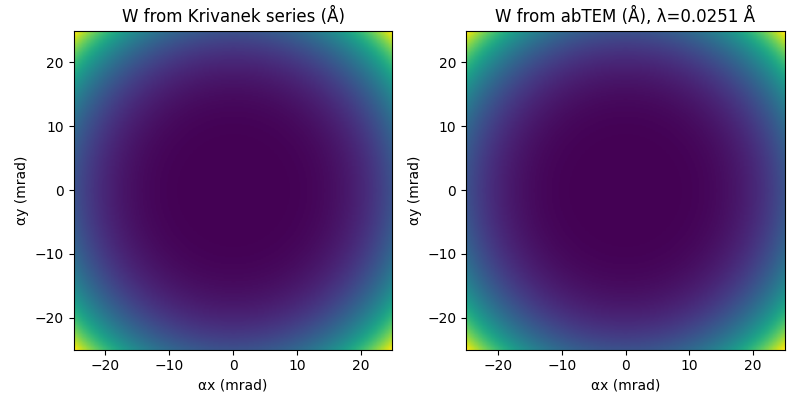

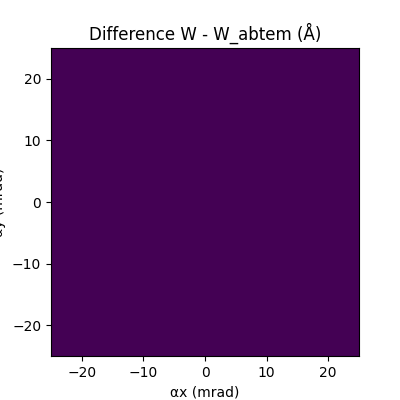

In [70]:
# Grid in angle space (radians)
N = 241
a_max_mrad = 25.0
a_max = a_max_mrad * 1e-3  # rad
ax = np.linspace(-a_max, a_max, N)
ay = np.linspace(-a_max, a_max, N)
AX, AY = np.meshgrid(ax, ay, indexing="xy")
E_eV = 200_000.0
wavelength = abtem.core.energy.energy2wavelength(E_eV) # 200 keV in Å

# Instance with defaults = 0.0 and C30 overridden
coeffs = KrivanekCoeffs(C30=1e-3)

alpha = np.hypot(AX, AY)    # radians
phi = np.arctan2(AY, AX)    # radians

# Compute analytic W and kick
W = W_krivanek(alpha, phi, coeffs)  # wrap to [-π, π]

abtem_coeffs = coeffs.__dict__
W_ab =  W_krivanek_abtem(AX, AY, abtem_coeffs, energy_eV=E_eV)# wrap to [-π, π]

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(W, extent=[-a_max_mrad, a_max_mrad, -a_max_mrad, a_max_mrad])
axs[0].set_title("W from Krivanek series (Å)")
axs[0].set_xlabel("αx (mrad)")
axs[0].set_ylabel("αy (mrad)")
im = axs[1].imshow(W_ab, extent=[-a_max_mrad, a_max_mrad, -a_max_mrad, a_max_mrad])
axs[1].set_title(f"W from abTEM (Å), λ={wavelength:.4f} Å")
axs[1].set_xlabel("αx (mrad)")
axs[1].set_ylabel("αy (mrad)")
plt.tight_layout()

# Difference
diff = np.round(W - W_ab, decimals=6)
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
im = axs.imshow(diff, extent=[-a_max_mrad, a_max_mrad, -a_max_mrad, a_max_mrad])
axs.set_title("Difference W - W_abtem (Å)")
axs.set_xlabel("αx (mrad)")
axs.set_ylabel("αy (mrad)")

In [85]:
scale = 1  # scale to microns

aperture_window_width = 2e-9
num_aper_pixels = 128
aperture_pixel_size = (aperture_window_width / num_aper_pixels, aperture_window_width / num_aper_pixels)
print(aperture_pixel_size)
aperture_radius = 1e-9

num_beams = int(5e4)
r1x, r1y = fibonacci_spiral(nb_samples=num_beams, radius=aperture_radius, alpha=0)

wavelength = 2e-12
k = 2 * np.pi / wavelength
wo = wavelength * 4
print(wo)
#area of aperture
aperture_area = np.pi * aperture_radius**2
scale_factor = aperture_area / (wo ** 2 * num_beams * np.pi)

(1.5625e-11, 1.5625e-11)
8e-12


In [86]:
# Gaussian Beam Input
xs = r1x
ys = r1y
dxs = np.zeros(num_beams)
dys = np.zeros(num_beams)
zs = np.zeros(num_beams)
pathlengths = np.zeros(num_beams)
ones = np.ones(num_beams)
amplitudes = np.ones(num_beams) * scale_factor
radii_of_curv = np.full((num_beams, 2), np.inf)
theta = np.zeros(num_beams)
wavelength = wavelength
wavelengths = np.full((num_beams,), wavelength)
wo = wo
waist_xy = np.full((num_beams, 2), wo)

rays = GaussianRay(
    x=xs, 
    y=ys, 
    dx=dxs,
    dy=dys, 
    z=zs,
    pathlength=pathlengths, 
    _one=ones, 
    amplitude=amplitudes, 
    waist_xy=waist_xy,  # 1x2 per Gaussian Ray
    radii_of_curv=radii_of_curv,  # 1x2 per Gaussian Ray
    wavelength=wavelengths, 
    theta=theta,
)

input_aperture_grid = Detector(
    pixel_size=aperture_pixel_size,
    shape=(num_aper_pixels, num_aper_pixels),
    z=0.0,
)


In [87]:
# Warm up JIT by evaluating a single-ray batch
rays_single = GaussianRay(
    x=xs[:1],
    y=ys[:1],
    dx=dxs[:1],
    dy=dys[:1],
    z=zs[:1],
    pathlength=pathlengths[:1],
    _one=ones[:1],
    amplitude=amplitudes[:1],
    waist_xy=waist_xy[:1],
    radii_of_curv=radii_of_curv[:1],
    wavelength=wavelengths[:1],
    theta=theta[:1],
)
_ = evaluate_gaussian_input_image(rays_single, input_aperture_grid, batch_size=1)


In [88]:
# Full evaluation
aperture_image = evaluate_gaussian_input_image(rays, input_aperture_grid, batch_size=100)

Text(0.5, 1.0, 'Gauss Phase at input plane')

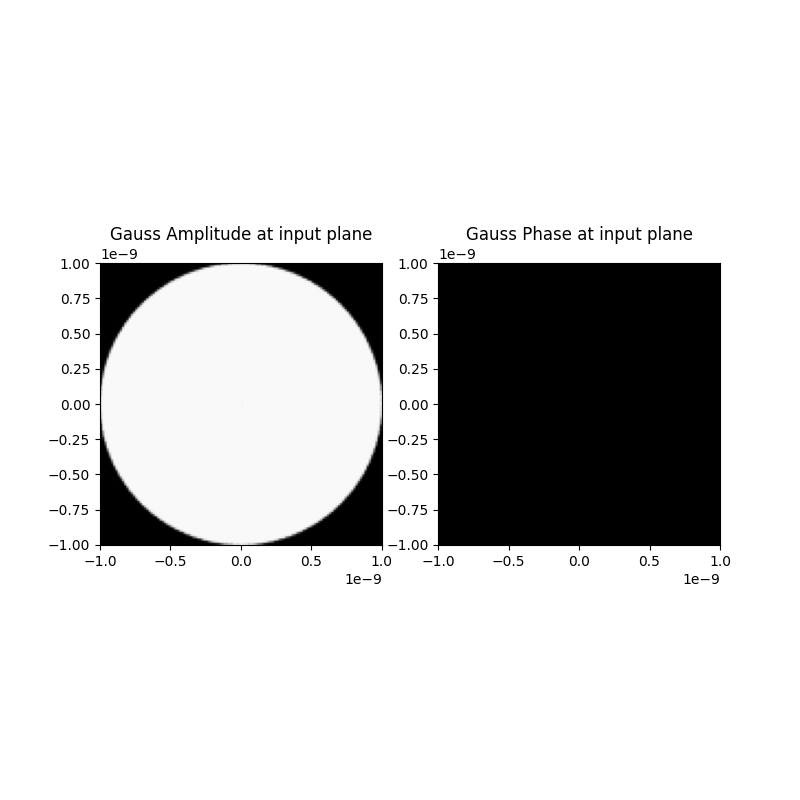

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

# Amplitude at input plane
ax[0].imshow(jnp.abs(aperture_image), cmap='gray', extent=[-aperture_window_width/2, aperture_window_width/2, -aperture_window_width/2, aperture_window_width/2])
ax[0].set_title('Gauss Amplitude at input plane')

# Phase at input plane
ax[1].imshow(jnp.angle(aperture_image), cmap='gray', extent=[-aperture_window_width/2, aperture_window_width/2, -aperture_window_width/2, aperture_window_width/2])
ax[1].set_title('Gauss Phase at input plane')

In [120]:
M1 = -100
F1 = 1e-2

defocus = 1e-12
L1_z1 = F1 * (1/M1 - 1)
L1_z2 = F1 * (1 - M1)

coeffs = KrivanekCoeffs(C30=0, C21=0.0)
parallel_beam = ParallelBeam(z=0.0 + defocus, radius=aperture_radius)
lens = AberratedLensKrivanek(focal_length=F1, z=F1, coeffs=coeffs)
detector = Detector(z=F1 + F1, pixel_size=(aperture_pixel_size[0] * 30000, aperture_pixel_size[1] * 30000), shape=(128, 128))
detector_xy = detector.coords_1d
model = [
    parallel_beam,
    lens,
    detector,
]

input_rays = rays.derive(z=jnp.zeros(num_beams) + defocus)
det_image_in_focus = make_gaussian_image(input_rays[1:], model, batch_size=1000)

In [121]:
out_rays = run_to_end(input_rays, model)

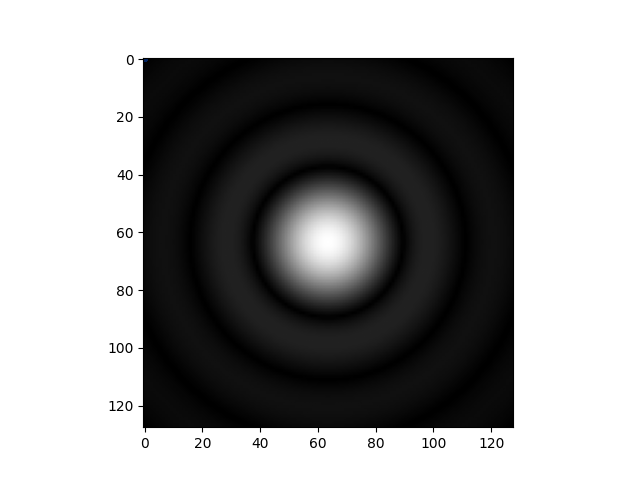

: 

In [ ]:
plt.figure()
plt.imshow(jnp.abs(det_image_in_focus), cmap='gray')
plt.plot(out_rays.x, out_rays.y, '.', alpha=0.01)

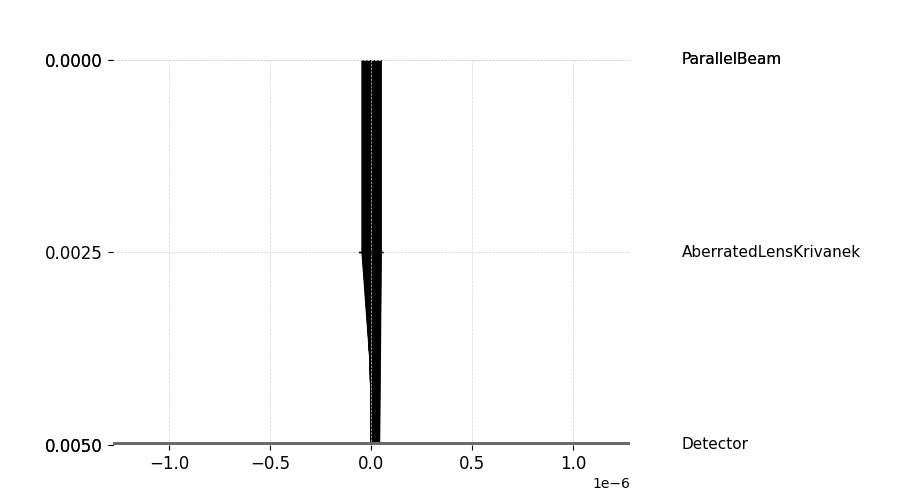

In [32]:
from temgym_core.plotting import plot_model, PlotParams
plot_params = PlotParams(ray_color='k', extent_scale = 1.2, lens_height=1e-6)
fig, ax = plot_model(model, rays = input_rays[0::1000], plot_params=plot_params, yscale='linear')

Focal length: 2.500 mm
Aperture radius: 0.050 μm
Maximum angle: 0.020 mrad


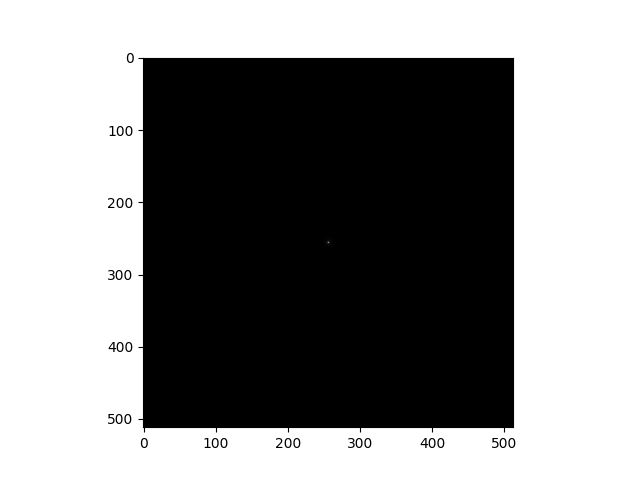

In [13]:
focal_length = F1  # 2.5mm

aper_x, aper_y = input_aperture_grid.coords_1d
aper_grid_width_x = aper_x[-1] - aper_x[0]
aper_grid_width_y = aper_y[0] - aper_y[-1]

aperture_radius = 0.5 * aper_grid_width_x
a_max_rad_x = 0.5 * aper_grid_width_x / focal_length
a_max_rad_y = 0.5 * aper_grid_width_y / focal_length
a_max_rad = min(a_max_rad_x, a_max_rad_y)

print(f"Focal length: {focal_length*1000:.3f} mm")
print(f"Aperture radius: {aperture_radius*1e6:.3f} μm") 
print(f"Maximum angle: {a_max_rad*1000:.3f} mrad")

ax = np.linspace(-a_max_rad, a_max_rad, num_aper_pixels)
ay = np.linspace(-a_max_rad, a_max_rad, num_aper_pixels)
AX, AY = np.meshgrid(ax, ay, indexing="xy")

W_abtem = W_krivanek_abtem(AX, AY, coeffs=coeffs.__dict__, energy_eV=E_eV)
chi_abtem = np.exp(-1j * (2.0 * np.pi / wavelength) * W_abtem)  # in radians

probe = np.fft.fftshift(np.fft.ifft2(aperture_image * chi_abtem))

plt.figure()
plt.imshow(jnp.abs(probe), cmap='gray')

In [14]:
# probe = abtem.Probe(
#     sampling=0.05,
#     extent=20,
#     energy=80e3,
#     semiangle_cutoff=20,
#     C10=50,
#     Cs=-50e-6 * 1e10,
# )


# intensity = probe.build().intensity().compute()
# phase = probe.build().phase()

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# intensity.show(cbar=True, title="probe intensity", ax=ax1)
# phase.show(cbar=True, title="probe phase", cmap="hsluv", ax=ax2)

# plt.tight_layout()